----------------
# １．ライブラリのインポート

In [1]:
# 基本的なライブラリ
import numpy as np
import pandas as pd
from numpy.typing import NDArray
from scipy import stats

# Scikit-learn関連
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.utils.validation import check_X_y
from sklearn.model_selection import train_test_split

# 抽象基底クラス (ABC)
from abc import ABCMeta, abstractmethod

# タイピングのサポート
from typing import Optional

# 可視化の設定
import matplotlib.pyplot as plt
import japanize_matplotlib
import itertools

plt.style.use("ggplot")

# 計算時間
import time

--------
# ２．実験設定

## 2.1 実験設定

In [2]:
### 実験データの設定 ###
TARGET = "GMV"  # "GMV" or "BCR"（目的変数）
DATA = "part"  # "all" or "part"（データすべてを使うか一部を使うか）
DATA_SIZE = 2000  # 訓練データとテストデータあわせたデータサイズ（母集団サイズ）
TEST_SIZE = 0.5  # テストデータの比率
THRESHOLD = 0.3  # 外れ値除外の閾値


### 実験設定 ###
SAMPLE_SIZE = 100  # 標本サイズ
N_TRIALS = 10  # 試行回数（標本平均を求める回数）
m_VALUE = 2  # 最適標本配分における各クラスタの最小標本数
RANDOM_STATE = 0  # 乱数シード
SEED = 0


### 実験方法 ###
# クラスタリング
CLUSTERING_METHOD = "kmeans"  # "gmm" or "kmeans" or "xmeans"
N_CLUSTERS = 10  # クラスタ数
K_MIN = 2
K_MAX = 10

# 特徴量選択
ALLOCATION_METHODS = [
    # "Proportional",
    # "Post",
    "Optimal",
]  # 各手法の時間をはかるときは１つにする
SELECT_MAXIMUM_FEATURES = "yes"  # "yes" or "no"（特徴量数が MAXIMUM_FEATURES_TO_SELECT になるまで選ぶかいなか）
MAXIMUM_FEATURES_TO_SELECT = 5  # 選択される最大の特徴量(特徴量選択ありの場合)


### 可視化 ###
TITLE_SIZE = 20
LABEL_SIZE = 15
TICK_SIZE = 12.5

## 2.2 手法の名前

In [3]:
if CLUSTERING_METHOD == "kmeans":
    METHOD_NAME = "SFS-Kmeans-Var"
if CLUSTERING_METHOD == "xmeans":
    METHOD_NAME == "SFS-Xmeans-Var"
if CLUSTERING_METHOD == "gmm":
    METHOD_NAME == "SFS-GMM-Var"

-----------
# ３．データの前処理

## 3.1 データ読み込み

In [4]:
# df1(all the data)
df1 = pd.read_csv(
    R"C:\Users\HaruMomozu\Documents\aug_first_cpn_data_for_ab_test_sensibility_tsukuba.csv"
)

features_list = [
    "hist_4_day_buy_num",
    "hist_4_day_gmv",
    "his_4_day_is_buy",
    "hist_30_day_buy_days",
    "hist_30_day_buy_num",
    "hist_30_day_gmv",
    "hist_30_day_buy_recency",
    "hist_30_day_pay_days",
    "hist_30_day_atpu",
    "hist_30_day_gpv",
    "hist_30_day_pay_recency",
    "hist_30_day_list_days",
    "hist_30_day_list_num",
    "hist_30_day_list_recency",
    "hist_30_day_like_count",
    "hist_30_day_like_count_not_deleted",
    "hist_30_day_like_recency",
]

# df2(subset of the data)
df2 = df1.iloc[:DATA_SIZE]

if DATA == "all":
    df = df1
if DATA == "part":
    df = df2

ALL_FEATURES_INDEX = [i for i in range(len(features_list))]
print(ALL_FEATURES_INDEX)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


## 3.2 "GMV" から新しい変数 "BCR" 作成

In [5]:
df = df.copy()
df["BCR"] = np.where(df["GMV"] > 0, 1, 0)

## 3.3 外れ値除去

In [6]:
def remove_outliers_zscore(
    data: pd.DataFrame, metric: str, threshold: float
) -> pd.DataFrame:
    z_scores = np.abs(stats.zscore(data[metric]))
    data = data[(z_scores < threshold)]
    return data

In [7]:
df = remove_outliers_zscore(data=df, metric=TARGET, threshold=THRESHOLD)
df = df.reset_index(drop=True)  # 行を詰める

print("外れ値除外前のデータ数（訓練+テスト）:", DATA_SIZE)
print("外れ値除外後のデータ数（訓練+テスト）:", len(df))

外れ値除外前のデータ数（訓練+テスト）: 2000
外れ値除外後のデータ数（訓練+テスト）: 1865


## 3.4 訓練データとテストデータに分割

In [8]:
X_all = df[features_list].to_numpy()
y_all = df[TARGET].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

print("訓練データのデータ数:", len(X_train))
print("テストデータのデータ数:", len(X_test))

訓練データのデータ数: 932
テストデータのデータ数: 933


## 3.5 標準化

In [9]:
sc = StandardScaler()
# 訓練データに基づいてfit
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

-------------
# ４．特徴量選択

In [10]:
TIME_DICT = {}
SELECTED_FEATURES_DICT = {}

### Allocation_in_Wrapper Class で特徴量選択

In [11]:
class Allocation_in_Wrapper(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        maximum_features_to_select: int,
        n_clusters: int,
        clustering_method: str = "kmeans",
        random_state: int = 0,
        select_maximum_features: str = "yes",
        k_min: int = 2,
        k_max: int = 10,
        allocation_method: str = "Proportional",
        sample_size: int = 10,
        n_trials: int = 100,
        m_value=2,
        M: Optional[NDArray] = None,
    ):
        self.maximum_features_to_select = maximum_features_to_select
        self.n_clusters = n_clusters
        self.clustering_method = clustering_method
        self.random_state = random_state
        self.select_maximum_features = select_maximum_features
        self.k_min = k_min
        self.k_max = k_max
        self.allocation_method = allocation_method
        self.sample_size = sample_size
        self.n_trials = n_trials
        self.m_value = m_value
        self.M = M

    def fss(self, X: pd.DataFrame, y: pd.DataFrame) -> "Allocation_in_Wrapper":
        X, y = check_X_y(X, y)
        n_all_features = X.shape[1]  # 総特徴量数

        features_score_dict = {}

        # 選ばれた特徴量と残っている特徴量の初期化
        current_features = []
        remaining_features = list(range(n_all_features))

        if self.select_maximum_features == "no":
            best_score = -np.inf

        while len(current_features) < self.maximum_features_to_select:
            best_feature = None  # 選ぶ特徴量の初期化

            if self.select_maximum_features == "yes":
                best_score = -np.inf

            for feature in remaining_features:
                temp_features = current_features + [
                    feature
                ]  # 特徴量をひとつ加え、score計算
                score, n_clusters = self.crit(X[:, temp_features], y)

                if score > best_score:
                    best_score = score
                    best_feature = feature
                    best_N_cluster_size = self.N_cluster_size
                    best_n_clusters = n_clusters
                    best_n_cluster_size = self.n_cluster_size

            if best_feature is not None:
                current_features.append(best_feature)
                remaining_features.remove(best_feature)
                num_of_features = len(current_features)
                print(
                    "num_of_features:",
                    num_of_features,
                    "current_features:",
                    current_features,
                    ", score:",
                    best_score,
                    "best_n_clusters:",
                    best_n_clusters,
                    "best_N_cluster_size:",
                    best_N_cluster_size,
                    "best_n_cluster_size:",
                    best_n_cluster_size,
                )

                features_score_dict[str(num_of_features)] = best_score  # 確認用
            else:
                break

        self.selected_features_index = current_features
        self.features_score_dict = features_score_dict

        return self

    def crit(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        # クラスタリング手法がGMMの場合
        if self.clustering_method == "gmm":
            model = GaussianMixture(
                n_components=self.n_clusters,
                random_state=self.random_state,
                init_params="kmeans",
            )
        # クラスタリング手法がKMEANSの場合
        if self.clustering_method == "kmeans":
            model = KMeans(
                n_clusters=self.n_clusters,
                random_state=self.random_state,
            )
        if self.clustering_method == "xmeans":
            model = self.xmeans(X)

        model.fit(X)
        self.N_cluster_label = model.predict(X)
        self.N_cluster_size = np.bincount(self.N_cluster_label)
        n_clusters = len(np.unique(self.N_cluster_label))

        var = self.cauculate_var(X, y)
        score = -var

        return score, n_clusters

    def compute_bic(self, X: pd.DataFrame, kmeans: KMeans) -> float:
        # クラスタリング結果の取得
        labels = kmeans.labels_
        clusters = kmeans.cluster_centers_
        n_clusters = len(clusters)
        n = len(X)
        m = X.shape[1]
        # クラスター内の分散の合計
        variance = np.sum(
            [
                np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
                for i in range(n_clusters)
            ]
        )
        # BIC の計算
        bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
        return bic

    def xmeans(self, X: pd.DataFrame) -> KMeans:
        kmeans = KMeans(
            n_clusters=self.k_min, random_state=self.random_state
        )  # 初期クラスター数で KMeans を実行
        kmeans.fit(X)
        best_bic = self.compute_bic(X, kmeans)
        best_kmeans = kmeans
        for k in range(self.k_min + 1, self.k_max + 1):
            kmeans = KMeans(n_clusters=k, random_state=self.random_state)
            kmeans.fit(X)
            # BIC を計算
            current_bic = self.compute_bic(X, kmeans)
            # BIC が改善される場合、クラスタ数を更新
            if current_bic < best_bic:
                best_bic = current_bic
                best_kmeans = kmeans
        # 最適なクラスタリング結果を返す
        return best_kmeans

    def cauculate_var(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        # 各戦略の標本数に基づいて目的変数の平均を推定
        y_hats = []
        for random_state in range(self.n_trials):
            if self.allocation_method == "Post":
                y_hat = self.estimate_y_mean_post(X, y)
            elif self.allocation_method == "Proportional":
                y_hat = self.estimate_y_mean_proportional(X, y)
            elif self.allocation_method == "Optimal":
                y_hat = self.estimate_y_mean_optimal(X, y)
            y_hats.append(y_hat)

        y_hats = np.array(y_hats)
        var = y_hats.var()

        return var

    def estimate_y_mean_post(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        n_cluster_size = np.array([self.sample_size])
        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0

        all_indices = np.arange(len(y))
        sample_indices = np.random.choice(all_indices, n_cluster_size[0], replace=False)
        sample_labels = np.array([self.N_cluster_label[i] for i in sample_indices])

        self.n_cluster_size = np.bincount(sample_labels)

        for h in np.unique(sample_labels):
            index = np.where(sample_labels == h)[0]
            sample = y[sample_indices[index]]
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_proportional(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        self.n_cluster_size = self.proportional(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        for h in range(self.n_cluster_size.shape[0]):
            if 0 < self.n_cluster_size[h]:
                sample: NDArray = np.random.choice(
                    y[self.N_cluster_label == h], self.n_cluster_size[h], replace=False
                )
                y_sample_mean = sample.mean()  # サンプリングした標本の平均
                y_hat += y_sample_mean * weights[h]
        return y_hat

    def estimate_y_mean_optimal(self, X: pd.DataFrame, y: pd.DataFrame) -> float:
        self.n_cluster_size, labels_for_optimal = self.optimal(X, y)

        weights = self.N_cluster_size / self.N_cluster_size.sum()
        y_hat = 0
        i = -1
        for h in labels_for_optimal:
            i += 1
            sample: NDArray = np.random.choice(
                y[self.N_cluster_label == h], self.n_cluster_size[i], replace=False
            )
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
        return y_hat

    def proportional(self, X: pd.DataFrame, y: pd.DataFrame) -> NDArray:
        n_cluster_size: NDArray = np.round(
            self.N_cluster_size / self.N_cluster_size.sum() * self.sample_size
        ).astype(int)

        if n_cluster_size.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n_cluster_size[np.argmax(n_cluster_size)] -= (
                n_cluster_size.sum() - self.sample_size
            )
        if n_cluster_size.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n_cluster_size[np.argmax(n_cluster_size)] += (
                -n_cluster_size.sum() + self.sample_size
            )
        return n_cluster_size

    def optimal(self, X: pd.DataFrame, y: pd.DataFrame) -> NDArray:
        cluster_size_all = np.bincount(self.N_cluster_label)
        cluster_size_for_optimal = []
        labels_for_optimal = []
        for i in range(len(cluster_size_all)):
            if cluster_size_all[i] >= 2:
                cluster_size_for_optimal.append(cluster_size_all[i])
                labels_for_optimal.append(i)
        n_clusters_for_optimal = len(cluster_size_for_optimal)
        cluster_size_for_optimal = np.array(cluster_size_for_optimal)

        self.m = np.full(n_clusters_for_optimal, self.m_value)

        S = np.array([np.var(y[self.N_cluster_label == h]) for h in labels_for_optimal])
        d = (cluster_size_for_optimal**2) * S

        n_cluster_size = self.m.copy()  # 初期値
        M = self.M.copy() if self.M is not None else cluster_size_for_optimal.copy()
        I = np.arange(n_clusters_for_optimal)  # noqa #クラスタのインデックス

        while (n_cluster_size.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(n_clusters_for_optimal)
            delta[I] = (d / (n_cluster_size + 1) - d / n_cluster_size)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n_cluster_size[h_star] + 1 <= M[h_star]:
                n_cluster_size[h_star] = n_cluster_size[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        # 制約チェック
        print(n_cluster_size)

        assert (
            n_cluster_size.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n_cluster_size >= self.m
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n_cluster_size <= self.M
            ), "Maximum sample size constraint is not satisfied"

        return n_cluster_size, labels_for_optimal

    def get_selected_features_index(self):
        return self.selected_features_index  # 選択された特徴量のインデックス

    def get_features_score_dict(self):
        return self.features_score_dict

In [12]:
def process_allocation_in_wrapper(
    instance: "Allocation_in_Wrapper", X: NDArray, y: NDArray
) -> tuple[list, dict[int, float]]:
    instance.fss(X, y)
    selected_features_index = instance.get_selected_features_index()
    features_score_dict = instance.get_features_score_dict()
    selected_features_index = np.array(selected_features_index)

    return selected_features_index, features_score_dict

### インスタンスのリスト作成

In [13]:
instances = []
for allocation_method in ALLOCATION_METHODS:
    instances.append(
        (
            allocation_method,
            Allocation_in_Wrapper(
                maximum_features_to_select=MAXIMUM_FEATURES_TO_SELECT,
                n_clusters=N_CLUSTERS,
                clustering_method=CLUSTERING_METHOD,
                random_state=RANDOM_STATE,
                select_maximum_features=SELECT_MAXIMUM_FEATURES,
                k_min=K_MIN,
                k_max=K_MAX,
                allocation_method=allocation_method,
                sample_size=SAMPLE_SIZE,
                n_trials=N_TRIALS,
                m_value=m_VALUE,
            ),
        )
    )

### Allocaiton in Wrapper の実施

In [14]:
features_score_dict_dict = {}

# 各インスタンスに対して処理を実行
for allocation_method, instance in instances:
    print("[", allocation_method, "]")
    start_time = time.time()
    selected_features_index, features_score_dict = process_allocation_in_wrapper(
        instance, X_train_std, y_train
    )
    end_time = time.time()

    SELECTED_FEATURES_DICT[allocation_method] = selected_features_index
    TIME_DICT[allocation_method] = end_time - start_time

    features_score_dict_dict[allocation_method] = features_score_dict

[ Optimal ]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[43  2 31 13  2  5  2  2]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[61  2  4  2 12  2  2 15]
[57 43]
[57 43]
[57 43]
[57 43]
[57 43]
[57 43]
[57 43]
[57 43]
[57 43]
[57 43]


c:\Users\HaruMomozu\Desktop\momozu\ABtesting\.venv\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (10). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[16  8 15 14  2  3 14  9 13  6]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[23  3 12  9  2 19  7  2 23]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[36  2  9  2 19  3  2 27]
[11  9  8  3 23 16 14  2  9  5]
[11  9  8  3 23 16 14  2  9  5]
[11  9  8  3 23 16 14  2  9  5]
[11  9  8  3 23 16 14  2  9  5]
[1

In [15]:
print(features_score_dict_dict)

{'Optimal': {'1': -8295.3343624775, '2': -9253.745887409492, '3': -6063.23280226698, '4': -9839.151063326324, '5': -9483.082042806684}}


## 4.4 特徴量選択の結果

### スコア（-分散）の推移

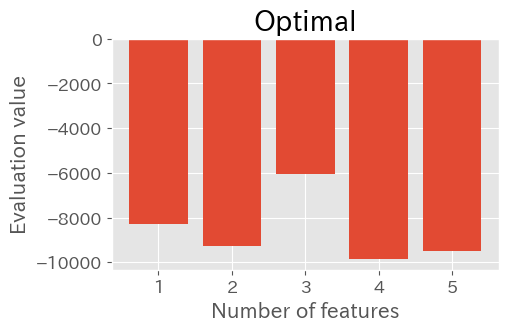

In [16]:
for allocation_method, instance in instances:
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(
        features_score_dict_dict[allocation_method].keys(),
        features_score_dict_dict[allocation_method].values(),
    )
    plt.title(f"{allocation_method}", fontsize=TITLE_SIZE)
    plt.xlabel("Number of features", fontsize=LABEL_SIZE)
    plt.ylabel("Evaluation value", fontsize=LABEL_SIZE)
    # plt.ylim(,)
    plt.tick_params(axis="both", labelsize=TICK_SIZE)
    plt.show()

### 分散削減率の推移

In [17]:
def cauculate_var_random(y: NDArray, seed: int, n_trials: int, sample_size) -> float:
    np.random.seed(seed)
    y_hats = []
    for i in range(n_trials):
        sample = np.random.choice(y, sample_size, replace=False)
        y_hat_random = sample.mean()
        y_hats.append(y_hat_random)
    var_random = np.array(y_hats).var()

    return var_random

In [18]:
VAR_RANDOM_TRAIN = cauculate_var_random(
    y=y_train, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)

In [19]:
features_reduction_rate_dict_dict = {}
for allocation_method, score_dict in features_score_dict_dict.items():
    features_reduction_rate_dict_dict[allocation_method] = {}
    for n_features, score in score_dict.items():
        reduction_rate = (1 - (-score / VAR_RANDOM_TRAIN)) * 100
        features_reduction_rate_dict_dict[allocation_method][n_features] = (
            reduction_rate
        )

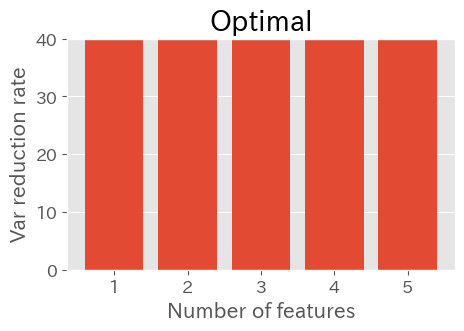

In [20]:
for allocation_method, instance in instances:
    # 棒グラフを作成
    plt.figure(figsize=(5, 3))
    plt.bar(
        features_reduction_rate_dict_dict[allocation_method].keys(),
        features_reduction_rate_dict_dict[allocation_method].values(),
    )
    plt.title(f"{allocation_method}", fontsize=TITLE_SIZE)
    plt.xlabel("Number of features", fontsize=LABEL_SIZE)
    plt.ylabel("Var reduction rate", fontsize=LABEL_SIZE)
    plt.ylim(0, 40)
    plt.tick_params(axis="both", labelsize=TICK_SIZE)
    plt.show()

### 特徴量選択の結果

In [21]:
for allocation_method in ALLOCATION_METHODS:
    print(f"【{allocation_method}】")
    print("選択された特徴量：", SELECTED_FEATURES_DICT[allocation_method])
    print(f"特徴量選択にかかった時間：{round(TIME_DICT[allocation_method], 3)} s")
    print()

【Optimal】
選択された特徴量： [ 4 12 15 10 14]
特徴量選択にかかった時間：3.881 s



# ５．クラスタリングと標本配分

## 5.1 クラスタリング

### 準備

In [22]:
def compute_bic(X: NDArray, kmeans: KMeans) -> float:
    labels = kmeans.labels_
    clusters = kmeans.cluster_centers_
    n_clusters = len(clusters)
    n = len(X)
    m = X.shape[1]
    variance = np.sum(
        [
            np.linalg.norm(X[labels == i] - clusters[i], axis=1).sum()
            for i in range(n_clusters)
        ]
    )
    bic = np.log(n) * n_clusters * m + n * np.log(variance / n)
    return bic


def xmeans(X: NDArray, k_min: int, k_max: int) -> KMeans:
    kmeans = KMeans(n_clusters=k_min, random_state=RANDOM_STATE)
    kmeans.fit(X)
    best_bic = compute_bic(X, kmeans)
    best_kmeans = kmeans
    for k in range(k_min + 1, k_max + 1):
        kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
        kmeans.fit(X)
        current_bic = compute_bic(X, kmeans)
        if current_bic < best_bic:
            best_bic = current_bic
            best_kmeans = kmeans
    return best_kmeans

In [23]:
def clustering(
    X: NDArray,
    allocation_methods: list,
    clustering_method: str,
    n_clusters: int,
    random_state: int,
    k_min: int,
    k_max: int,
    selected_features_dict: dict,
) -> tuple[dict, dict]:
    cluster_label_dict = {}
    cluster_size_dict = {}

    for allocation_method in allocation_methods:
        if clustering_method == "kmeans":
            model = KMeans(n_clusters=n_clusters, random_state=random_state)
        if clustering_method == "gmm":
            model = GaussianMixture(
                n_components=n_clusters, random_state=random_state, init_params="kmeans"
            )
        if clustering_method == "xmeans":
            model = xmeans(X, k_min=k_min, k_max=k_max)

        labels = model.fit_predict(X[:, selected_features_dict[allocation_method]])
        cluster_size = np.bincount(labels)

        cluster_label_dict[allocation_method] = labels
        cluster_size_dict[allocation_method] = cluster_size

    return cluster_label_dict, cluster_size_dict

### クラスタリングの実施

In [24]:
CLUSTER_LABEL_DICT_TRAIN, CLUSTER_SIZE_DICT_TRAIN = clustering(
    X=X_train_std,
    allocation_methods=ALLOCATION_METHODS,
    clustering_method=CLUSTERING_METHOD,
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    k_min=K_MIN,
    k_max=K_MAX,
    selected_features_dict=SELECTED_FEATURES_DICT,
)

CLUSTER_LABEL_DICT_TEST, CLUSTER_SIZE_DICT_TEST = clustering(
    X=X_test_std,
    allocation_methods=ALLOCATION_METHODS,
    clustering_method=CLUSTERING_METHOD,
    n_clusters=N_CLUSTERS,
    random_state=RANDOM_STATE,
    k_min=K_MIN,
    k_max=K_MAX,
    selected_features_dict=SELECTED_FEATURES_DICT,
)

In [25]:
def cauculate_cluster_size_for_optimal(
    cluster_size_list: list,
) -> list[int]:
    cluster_size_for_optimal = []
    for i in range(len(cluster_size_list)):
        if cluster_size_list[i] >= 2:
            cluster_size_for_optimal.append(cluster_size_list[i])

    return cluster_size_for_optimal


def cauculate_label_for_optimal(cluster_size_list: NDArray) -> list[int]:
    label_for_optimal = []
    for i in range(len(cluster_size_list)):
        if cluster_size_list[i] >= 2:
            label_for_optimal.append(i)

    return label_for_optimal


In [26]:
if "Optimal" in ALLOCATION_METHODS:
    CLUSTER_SIZE_FOR_OPTIMAL_TRAIN = cauculate_cluster_size_for_optimal(
        cluster_size_list=CLUSTER_SIZE_DICT_TRAIN["Optimal"]
    )
    LABEL_FOR_OPTIMAL_TRAIN = cauculate_label_for_optimal(
        cluster_size_list=CLUSTER_SIZE_DICT_TRAIN["Optimal"]
    )

    CLUSTER_SIZE_FOR_OPTIMAL_TEST = cauculate_cluster_size_for_optimal(
        cluster_size_list=CLUSTER_SIZE_DICT_TEST["Optimal"]
    )
    LABEL_FOR_OPTIMAL_TEST = cauculate_label_for_optimal(
        cluster_size_list=CLUSTER_SIZE_DICT_TEST["Optimal"]
    )


### クラスタリング結果

In [27]:
for allocation_method in ALLOCATION_METHODS:
    print(f"【{allocation_method}】")
    print(
        f"訓練データでの各層のクラスタサイズ：{CLUSTER_SIZE_DICT_TEST[allocation_method]}"
    )
    if allocation_method == "Optimal":
        print(
            f"（クラスタサイズが２以上の層のみ（最適標本配分用）：{CLUSTER_SIZE_FOR_OPTIMAL_TRAIN}"
        )

    print(
        f"テストデータでの各層のクラスタサイズ：{CLUSTER_SIZE_DICT_TEST[allocation_method]}"
    )
    if allocation_method == "Optimal":
        print(
            f"（クラスタサイズが２以上の層のみ（最適標本配分用）：{CLUSTER_SIZE_FOR_OPTIMAL_TEST}"
        )

【Optimal】
訓練データでの各層のクラスタサイズ：[315  23  27 136  22 105   1  33 220  51]
（クラスタサイズが２以上の層のみ（最適標本配分用）：[236, 99, 36, 17, 341, 24, 59, 114, 5]
テストデータでの各層のクラスタサイズ：[315  23  27 136  22 105   1  33 220  51]
（クラスタサイズが２以上の層のみ（最適標本配分用）：[315, 23, 27, 136, 22, 105, 33, 220, 51]


## 5.2 標本配分

### 基底クラス

In [28]:
class BaseAllocation(metaclass=ABCMeta):  # 抽象基底クラス（ABC）
    # 初期化クラス（n_samples(標本サイズ), H(クラスタ数)）
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        allocation_method: str,
        cluster_size_dict: dict,
    ):
        self.sample_size = sample_size
        self.random_state = random_state
        self.allocation_method = allocation_method
        self.N = cluster_size_dict[self.allocation_method]

    @abstractmethod
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """標本配分を解く

        Args:
            X (NDArray): データ (N x M)
            y (NDArray): 目的変数 (N)

        Raises:
            NotImplementedError: _description_

        Returns:
            NDArray: 各クラスタの標本数 (H, )

        Note:
            M: 特徴量数
            H: クラスタ数
        """
        # 具象クラスがsolveメゾッドを実装しない場合はNotImpleamentedErrorが発生
        raise NotImplementedError


### ① 比例配分（Proportional）

In [29]:
class Proportional(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """各クラスタ数に比例した標本数で分割する"""
        n: NDArray = np.round(self.N / self.N.sum() * self.sample_size).astype(int)

        if n.sum() > self.sample_size:
            # nの合計がn_samplesより大きい場合は一番標本数が多いクラスタから削る
            n[np.argmax(n)] -= n.sum() - self.sample_size

        if n.sum() < self.sample_size:
            # nの合計がn_samplesより小さい場合は一番標本数が多いクラスタにたす
            n[np.argmax(n)] += -n.sum() + self.sample_size

        return n

### ② 事後層化（Post）

In [30]:
class Post(BaseAllocation):
    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        """ランダムにn_samplesの標本を選択する"""
        n = np.array([self.sample_size])

        return n  # （例）n=[標本サイズ]

### ③ 最適標本配分（Optimal）

In [31]:
class Optimal(BaseAllocation):
    def __init__(
        self,
        sample_size: int,
        random_state: int,
        allocation_method: str,
        cluster_label_dict: dict,
        cluster_size_dict: dict,
        cluster_size_for_optimal: list,
        label_for_optimal: dict,
        m_value: int,  # 標本サイズ下限
        M: Optional[NDArray] = None,  # 標本サイズ上限 #Optional(Noneである可能性がある)
    ):
        super().__init__(
            sample_size,
            random_state,
            allocation_method,
            cluster_size_dict,
        )  # 基底クラスBaseAllocation（スーパークラス）の初期化メゾッドを呼び出す
        self.cluster_label = cluster_label_dict[self.allocation_method]
        self.N_for_optimal = np.array(cluster_size_for_optimal)
        self.labels = label_for_optimal
        self.m_value = m_value  # 各クラスタの最小標本サイズ (H, )
        self.M = M  # 各クラスタの最大標本サイズ (H, ), (指定しない場合はクラスタサイズ)

    def solve(self, X: NDArray, y: NDArray) -> NDArray:
        # S:クラスタ毎の目的変数のvarianceを要素とする配列 (H, )
        S = np.array(
            [np.var(y[self.cluster_label == h]) for h in self.labels]
        )  # 層hのデータが１つのときはS[h]は0になる
        d = (self.N_for_optimal**2) * S  # (H, )

        self.m = np.full(len(self.labels), self.m_value)
        n = self._simple_greedy(n=self.m.copy(), d=d)

        # 制約チェック
        self._check_constraints(n)

        return n

    def _simple_greedy(self, n: NDArray, d: NDArray) -> NDArray:
        M = self.M.copy() if self.M is not None else self.N_for_optimal.copy()
        I = np.arange(len(self.labels))  # noqa #クラスタのインデックス配列
        while (n.sum() != self.sample_size) and len(I) != 0:
            delta = np.zeros(len(self.labels))
            delta[I] = (d / (n + 1) - d / n)[I]
            h_star = np.argmin(delta[I])
            h_star = I[h_star]

            if n[h_star] + 1 <= M[h_star]:
                n[h_star] = n[h_star] + 1
            else:
                # Iの要素h_starを削除
                I_ = I.tolist()
                I_ = [i for i in I_ if i != h_star]
                I = np.array(I_)  # noqa

        return n

    def _check_constraints(self, n: NDArray):
        assert (
            n.sum() <= self.sample_size
        ), f"Total sample size is over than {self.sample_size}"
        assert np.all(
            n >= self.m_value
        ), "Minimum sample size constraint is not satisfied"
        if self.M is not None:
            assert np.all(
                n <= self.M
            ), "Maximum sample size constraint is not satisfied"


### ポリシーの生成

In [32]:
def create_policies(
    sample_size: int,
    random_state: int,
    m_value: int,
    cluster_size_dict: dict,
    cluster_label_dict: dict,
    cluster_size_for_optimal: list,
    label_for_optimal: list,
    allocation_methods: list,
) -> list[BaseAllocation]:
    policies: list[BaseAllocation] = []
    if "Proportional" in allocation_methods:
        policies.append(
            Proportional(
                sample_size=sample_size,
                random_state=random_state,
                allocation_method="Proportional",
                cluster_size_dict=cluster_size_dict,
            )
        )
    if "Post" in allocation_methods:
        policies.append(
            Post(
                sample_size=sample_size,
                random_state=random_state,
                allocation_method="Post",
                cluster_size_dict=cluster_size_dict,
            )
        )
    if "Optimal" in allocation_methods:
        policies.append(
            Optimal(
                sample_size=sample_size,
                random_state=random_state,
                allocation_method="Optimal",
                cluster_size_dict=cluster_size_dict,
                cluster_label_dict=cluster_label_dict,
                cluster_size_for_optimal=cluster_size_for_optimal,
                label_for_optimal=label_for_optimal,
                m_value=m_value,
                M=None,
            )
        )

    return policies

In [33]:
policies_train = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    cluster_size_dict=CLUSTER_SIZE_DICT_TRAIN,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_for_optimal=CLUSTER_SIZE_FOR_OPTIMAL_TRAIN,
    label_for_optimal=LABEL_FOR_OPTIMAL_TRAIN,
    m_value=m_VALUE,
    allocation_methods=ALLOCATION_METHODS,
)

policies_test = create_policies(
    sample_size=SAMPLE_SIZE,
    random_state=RANDOM_STATE,
    cluster_size_dict=CLUSTER_SIZE_DICT_TEST,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_for_optimal=CLUSTER_SIZE_FOR_OPTIMAL_TEST,
    label_for_optimal=LABEL_FOR_OPTIMAL_TEST,
    m_value=m_VALUE,
    allocation_methods=ALLOCATION_METHODS,
)

### 標本配分の実施

In [34]:
def cauculate_allocation_dict(
    X: NDArray, y: NDArray, policies: list
) -> dict[str, NDArray]:
    allocation_dict = {}
    for policy in policies:
        n = policy.solve(X, y)
        allocation_dict[policy.__class__.__name__] = n

    return allocation_dict

In [35]:
ALLOCATION_DICT_TRAIN = cauculate_allocation_dict(
    X=X_train_std, y=y_train, policies=policies_train
)
ALLOCATION_DICT_TEST = cauculate_allocation_dict(
    X=X_test_std, y=y_test, policies=policies_test
)

### 標本配分の結果

In [36]:
print(f"【{METHOD_NAME}】")
for allocation_method in ALLOCATION_METHODS:
    print(
        f"訓練データでの標本配分 ({allocation_method}) : {ALLOCATION_DICT_TRAIN[allocation_method]}"
    )
    print(
        f"テストデータでの標本配分 ({allocation_method}) : {ALLOCATION_DICT_TEST[allocation_method]}"
    )

【SFS-Kmeans-Var】
訓練データでの標本配分 (Optimal) : [26  9  5  2 31  3  6 16  2]
テストデータでの標本配分 (Optimal) : [23  3  3 18  3 11  6 25  8]


---------------------
# ６．評価

## 6.1 標本平均の分散を計算（単純無作為抽出）

In [37]:
VAR_RANDOM_TEST = cauculate_var_random(
    y=y_test, seed=SEED, n_trials=N_TRIALS, sample_size=SAMPLE_SIZE
)

print(f"訓練データでの標本平均の分散 (Random) : {VAR_RANDOM_TRAIN}")
print(f"テストデータでの標本平均の分散 (Random) : {VAR_RANDOM_TEST}")

訓練データでの標本平均の分散 (Random) : 19834.385496000003
テストデータでの標本平均の分散 (Random) : 29357.45832900001


## 6.2 標本平均の分散を計算（層化抽出）

### 標本平均を計算する関数

In [38]:
def estimate_y_mean_proportional(
    n: NDArray, cluster_label: NDArray, y: NDArray
) -> float:
    N = np.unique(cluster_label, return_counts=True)[1]  # クラスタサイズ (H, )
    weights = N / N.sum()
    y_hat = 0
    for h in range(n.shape[0]):  # n.shape[0]:層の数
        if 0 < n[h]:
            sample: NDArray = np.random.choice(
                y[cluster_label == h], n[h], replace=False
            )
            y_sample_mean = sample.mean()  # サンプリングした標本の平均
            y_hat += y_sample_mean * weights[h]
    return y_hat


def estimate_y_mean_optimal(
    n: NDArray, cluster_label: NDArray, label_for_optimal: list, y: NDArray
) -> float:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0
    i = -1
    for h in label_for_optimal:  # n.shape[0]:層の数
        i += 1
        sample: NDArray = np.random.choice(y[cluster_label == h], n[i], replace=False)
        y_sample_mean = sample.mean()  # サンプリングした標本の平均
        y_hat += y_sample_mean * weights[h]
    return y_hat


def estimate_y_mean_post(n: NDArray, cluster_label: NDArray, y: NDArray) -> float:
    N = np.unique(cluster_label, return_counts=True)[1]
    weights = N / N.sum()
    y_hat = 0

    all_indices = np.arange(len(y))  # 全データのインデックス
    sample_indices = np.random.choice(all_indices, n[0], replace=False)
    sample_labels = np.array([cluster_label[i] for i in sample_indices])

    for h in np.unique(sample_labels):
        index = np.where(sample_labels == h)[0]
        sample = y[sample_indices[index]]
        y_sample_mean = sample.mean()
        y_hat += y_sample_mean * weights[h]
    return y_hat


### 分散を計算する関数

In [39]:
def cauculate_var_stratified_dict(
    y: NDArray,
    seed: int,
    n_trials: int,
    allocation_dict: dict,
    cluster_label_dict: dict,
    cluster_size_for_optimal: list,
    label_for_optimal: list,
) -> dict[str, float]:
    np.random.seed(seed)
    var_stratified_dict = {}

    for allocation_method, allocation in allocation_dict.items():
        y_hats = []
        for i in range(n_trials):
            if allocation_method == "Post":
                y_hat = estimate_y_mean_post(
                    n=allocation,
                    cluster_label=cluster_label_dict[allocation_method],
                    y=y,
                )
            elif allocation_method == "Proportional":
                y_hat = estimate_y_mean_proportional(
                    n=allocation,
                    cluster_label=cluster_label_dict[allocation_method],
                    y=y,
                )
            elif allocation_method == "Optimal":
                y_hat = estimate_y_mean_optimal(
                    n=allocation,
                    cluster_label=cluster_label_dict[allocation_method],
                    label_for_optimal=label_for_optimal,
                    y=y,
                )
            y_hats.append(y_hat)
        y_hats = np.array(y_hats)
        var = y_hats.var()
        var_stratified_dict[allocation_method] = var

    return var_stratified_dict

### 分散を計算

In [40]:
VAR_STRATIFIED_DICT_TRAIN = cauculate_var_stratified_dict(
    y=y_train,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict=ALLOCATION_DICT_TRAIN,
    cluster_label_dict=CLUSTER_LABEL_DICT_TRAIN,
    cluster_size_for_optimal=CLUSTER_SIZE_FOR_OPTIMAL_TRAIN,
    label_for_optimal=LABEL_FOR_OPTIMAL_TRAIN,
)
VAR_STRATIFIED_DICT_TEST = cauculate_var_stratified_dict(
    y=y_test,
    seed=SEED,
    n_trials=N_TRIALS,
    allocation_dict=ALLOCATION_DICT_TEST,
    cluster_label_dict=CLUSTER_LABEL_DICT_TEST,
    cluster_size_for_optimal=CLUSTER_SIZE_FOR_OPTIMAL_TEST,
    label_for_optimal=LABEL_FOR_OPTIMAL_TEST,
)

In [41]:
print("訓練データでの標本分散の平均")
print(VAR_STRATIFIED_DICT_TRAIN)
print("テストデータでの標本分散の平均")
print(VAR_STRATIFIED_DICT_TEST)

訓練データでの標本分散の平均
{'Optimal': 35917.70522096161}
テストデータでの標本分散の平均
{'Optimal': 25451.29176477081}


## 6.3 分散削減率の計算

In [42]:
def cauculate_reduction_rate_dict(
    var_stratified_dict: dict, var_random: float
) -> dict[str, float]:
    reduction_rate_dict = {}
    for allocation_method, var in var_stratified_dict.items():
        reduction_rate = (1 - var / var_random) * 100
        reduction_rate_dict[allocation_method] = reduction_rate

    return reduction_rate_dict

In [43]:
REDUCTION_RATE_DICT_TRAIN = cauculate_reduction_rate_dict(
    VAR_STRATIFIED_DICT_TRAIN, VAR_RANDOM_TRAIN
)

REDUCTION_RATE_DICT_TEST = cauculate_reduction_rate_dict(
    VAR_STRATIFIED_DICT_TEST, VAR_RANDOM_TEST
)

In [44]:
print(f"【{METHOD_NAME}】")
print("訓練データでの標本分散の平均の削減率")
print(REDUCTION_RATE_DICT_TRAIN)
print("テストデータでの標本分散の平均の削減率")
print(REDUCTION_RATE_DICT_TEST)

【SFS-Kmeans-Var】
訓練データでの標本分散の平均の削減率
{'Optimal': -81.08806662149995}
テストデータでの標本分散の平均の削減率
{'Optimal': 13.30553387985428}


## 6.4 結果のプロット

### プロットするための関数

In [45]:
def plot_bars(
    dicts, var_random, target, method_name, title_size, label_size, tick_size
) -> plt.Figure:
    fig, axs = plt.subplots(1, 2, figsize=(8, 2.5))
    ylabels = ["Var reduction rate", "Var"]
    if target == "GMV":
        ylims = [(0, 40), (0, 400000)]
    if target == "BCR":
        ylims = [(-100, 100), (0, 0.1)]

    for i, ax in enumerate(axs):
        data = list(dicts[i].values())
        labels = list(dicts[i].keys())
        bars = ax.bar(labels, data)
        if i == 0:
            for bar in bars:
                yval = bar.get_height()  # 各バーの高さ（値）
                ax.text(
                    bar.get_x() + bar.get_width() / 2,
                    yval,
                    round(yval, 2),
                    ha="center",
                    va="bottom",
                    fontsize=label_size,
                )  # 値をバーの上に表示
        if i == 1:
            ax.bar("Random", var_random, color="blue")
        ax.set_title(method_name, fontsize=title_size)
        ax.set_ylabel(ylabels[i], fontsize=label_size)
        ax.tick_params(axis="both", which="major", labelsize=tick_size)
        ax.set_ylim(ylims[i])
    plt.tight_layout()
    plt.show()

### 訓練データの結果

C:\Users\HaruMomozu\AppData\Local\Temp\ipykernel_23824\4147692014.py:32: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


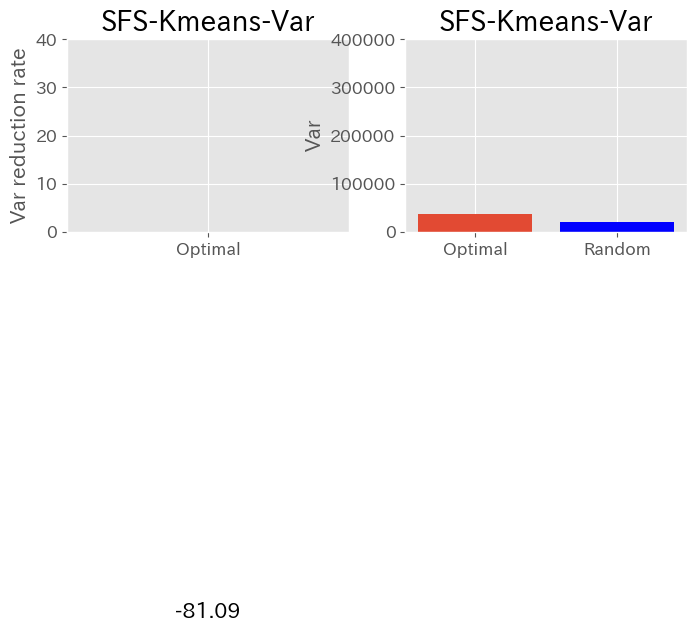

In [46]:
plot_bars(
    dicts=[
        REDUCTION_RATE_DICT_TRAIN,
        VAR_STRATIFIED_DICT_TRAIN,
    ],
    var_random=VAR_RANDOM_TRAIN,
    target=TARGET,
    method_name=METHOD_NAME,
    title_size=TITLE_SIZE,
    label_size=LABEL_SIZE,
    tick_size=TICK_SIZE,
)

### テストデータの結果

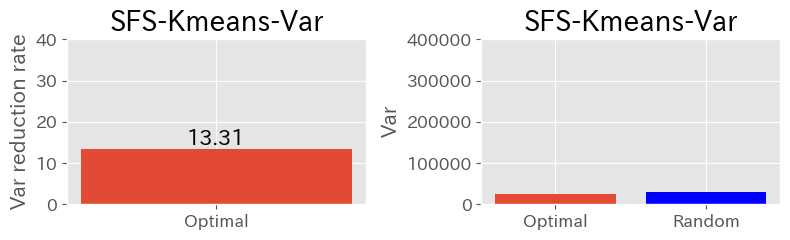

In [47]:
plot_bars(
    dicts=[
        REDUCTION_RATE_DICT_TEST,
        VAR_STRATIFIED_DICT_TEST,
    ],
    var_random=VAR_RANDOM_TEST,
    target=TARGET,
    method_name=METHOD_NAME,
    title_size=TITLE_SIZE,
    label_size=LABEL_SIZE,
    tick_size=TICK_SIZE,
)